In [1]:
%matplotlib ipympl
from pathlib import Path

import matplotlib.pyplot as plt
import napari
import numpy as np
import tifffile
from aicsimageio.readers import TiffGlobReader
from ipywidgets import Output
from mda_simulator import ImageGenerator
from mpl_interactions import hyperslicer
from napari_broadcastable_points import BroadcastablePoints
from pymmcore_plus import CMMCorePlus
from useq import MDASequence

from raman_mda_engine import RamanEngine, RamanTiffAndNumpyWriter, fakeAcquirer
from mda_simulator.mmcore import FakeDemoCamera

v = napari.Viewer()
dw, main_window = v.window.add_plugin_dock_widget("napari-micromanager")

core = CMMCorePlus.instance()
core.loadSystemConfiguration("../tests/test-config.cfg")

gen = ImageGenerator(N=4000)


# Create an object that will modify the `snap` method of the CMMCorePlus
# instance to return images from our ImageGenerator
fake_cam = FakeDemoCamera(
    gen,
    timing=0.5,  # how many real world seconds to wait to step the ImageGenerator time
    core=core,
)


metadata = {
    "raman": {
        "z": "center",
        "channel": "BF",
    },
}
init_sequence = MDASequence(
    channels=["BF"],
    time_plan={"interval": 0.5, "loops": 2},
    z_plan={"range": 50, "step": 5},
    axis_order="tpcz",
    stage_positions=[(0, 1, 1), (512, 128, 0)],
)

# points = v.add_points(ndim=4)



2022-07-05 15:07:51.403 | DEBUG    | pymmcore_plus._util:find_micromanager:47 - using MM path found in applications: /usr/local/lib/micro-manager
2022-07-05 15:07:51.404 | INFO     | pymmcore_plus.core._mmcore_plus:setDeviceAdapterSearchPaths:152 - setting adapter search paths: ['/usr/local/lib/micro-manager']
2022-07-05 15:07:51.613 | DEBUG    | pymmcore_plus._util:find_micromanager:47 - using MM path found in applications: /usr/local/lib/micro-manager


In [2]:
mda_output = Output()
with mda_output:
    core.run_mda(init_sequence)
    # .join()



2022-07-05 15:07:51.736 | INFO     | pymmcore_plus.mda._engine:_prepare_to_run:122 - MDA Started: Multi-Dimensional Acquisition ▶ nt: 2, np: 2, nc: 1, nz: 11
2022-07-05 15:07:51.738 | INFO     | pymmcore_plus.mda._engine:run:260 - metadata={} index={'t': 0, 'p': 0, 'c': 0, 'z': 0} channel=Channel(config='BF') exposure=None min_start_time=0.0 x_pos=0.0 y_pos=1.0 z_pos=-24.0 properties=None


In [3]:
engine = RamanEngine(spectra_collector=fakeAcquirer(), position_idx=1)
core.register_mda_engine(engine)


In [4]:
core.getImageWidth(), core.getImageHeight()

(512, 512)

In [5]:
cell_points = BroadcastablePoints(
    None,
    #               t, c, z
    broadcast_dims=(0, 2, 3),
    ndim=6,
    name="Cells",
    size=15,
    face_color="#aa0000ff",
    edge_color="#5500ffff",
)
bkd_points = BroadcastablePoints(
    None,
    #               t, c, z
    broadcast_dims=(0, 2, 3),
    ndim=6,
    name="Bkd points",
    size=15,
    face_color="#2d1f7f",
    edge_color="#5500ffff",
)

v.add_layer(cell_points)
v.add_layer(bkd_points)
engine.points_layers = [cell_points, bkd_points]

In [6]:
basic_sequence = MDASequence(
    metadata={"raman": {"z": "center"}},
    channels=["BF"],
    time_plan={"interval": 60, "loops": 3},
    # z_plan={"range": 30, "step": 10},
    z_plan={"relative": [-15, 0, 15]},
    axis_order="tpcz",
    stage_positions=[(0, 1, 1), (512, 128, 0)],
)
core.run_mda(basic_sequence)

2022-07-05 15:10:15.787 | INFO     | pymmcore_plus.mda._engine:_prepare_to_run:122 - MDA Started: Multi-Dimensional Acquisition ▶ nt: 3, np: 2, nc: 1, nz: 3


<Thread(Thread-6 (run), started 140274162193984)>

2022-07-05 15:10:15.789 | INFO     | raman_mda_engine._engine:run:172 - metadata={} index={'t': 0, 'p': 0, 'c': 0, 'z': 0} channel=Channel(config='BF') exposure=None min_start_time=0.0 x_pos=0.0 y_pos=1.0 z_pos=-14.0 properties=None
2022-07-05 15:10:15.838 | INFO     | raman_mda_engine._engine:run:172 - metadata={} index={'t': 0, 'p': 0, 'c': 0, 'z': 1} channel=Channel(config='BF') exposure=None min_start_time=0.0 x_pos=0.0 y_pos=1.0 z_pos=1.0 properties=None
2022-07-05 15:10:15.847 | INFO     | raman_mda_engine._engine:record_raman:134 - collecting raman: p=0, t=0
2022-07-05 15:10:15.861 | INFO     | raman_mda_engine._engine:run:172 - metadata={} index={'t': 0, 'p': 0, 'c': 0, 'z': 2} channel=Channel(config='BF') exposure=None min_start_time=0.0 x_pos=0.0 y_pos=1.0 z_pos=16.0 properties=None
2022-07-05 15:10:15.870 | INFO     | raman_mda_engine._engine:run:172 - metadata={} index={'t': 0, 'p': 1, 'c': 0, 'z': 0} channel=Channel(config='BF') exposure=None min_start_time=0.0 x_pos=512.0

FileNotFoundError: [Errno 2] No such file or directory: '/home/ian/Documents/oss/micro/raman-mda-engine/examples/data/run_5/t000_p000_c000_z000.tiff'

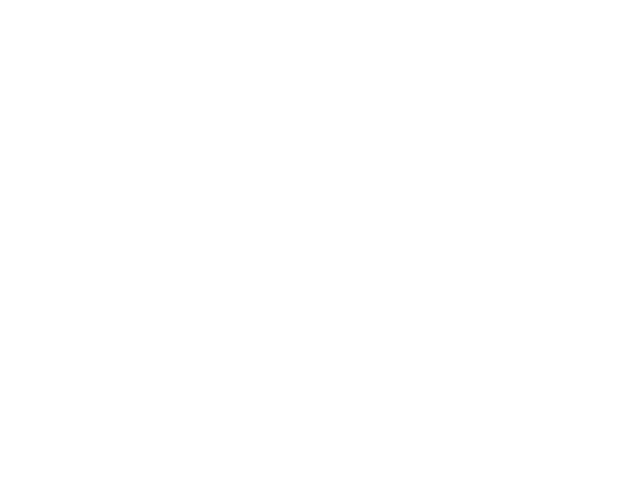

In [7]:
plt.figure()
plt.imshow(tifffile.imread("data/run_5/t000_p000_c000_z000.tiff"))

In [10]:
# actual_points = BroadcastablePoints(
#     None, broadcast_dims=(2, 3), ndim=6, name="Actual points", size=15, face_color="#aa0000ff"
# # )
# cell_points = BroadcastablePoints(
#     None,
#     #               t, c, z
#     broadcast_dims=(0, 2, 3),
#     ndim=6,
#     name="Cells",
#     size=15,
#     face_color="#aa0000ff",
#     edge_color="#5500ffff",
# )
# bkd_points = BroadcastablePoints(
#     None,
#     #               t, c, z
#     broadcast_dims=(0, 2, 3),
#     ndim=6,
#     name="Bkd points",
#     size=15,
#     face_color="#2d1f7f",
#     edge_color="#5500ffff",
# )

/home/ian/mambaforge/envs/pymm/lib/python3.10/site-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
2022-05-24 21:49:20.922 | WARNING  | pymmcore_plus.mda._engine:_check_canceled:141 - MDA Canceled: Multi-Dimensional Acquisition ▶ nt: 3, np: 2, nc: 1, nz: 3
2022-05-24 21:49:20.924 | INFO     | pymmcore_plus.mda._engine:_finish_run:234 - MDA Finished: Multi-Dimensional Acquisition ▶ nt: 3, np: 2, nc: 1, nz: 3
/home/ian/mambaforge/envs/pymm/lib/python3.10/site-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
